In [439]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('../')
import fn
from addition_dataset import GroupAddition

In [440]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualization

In [898]:
def smooth(losses, size=10):
    kernel = np.ones(size) / size
    smoothed_losses = np.convolve(losses, kernel, mode='same')
    return smoothed_losses

In [63]:
def plot_loss(all_losses, size=10):
    if len(all_losses) > 1:
        alpha = 0.5
    for c, losses in all_losses.items():
        plt.plot(smooth(losses, size=size), alpha=alpha, label=sorted(c)[0])
    if len(all_losses) > 1:
        plt.legend()
    plt.title(f'Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.show()

In [64]:
def compute_table_losses(b, depth, batch_size, architecture):

    # assert architecture is valid
    assert architecture in ['LSTM', 'transformer']
    
    # get carry tables for base
    with open('../pickles/all_tables.pickle', 'rb') as f:
        all_tables = pickle.load(f)
    tables = all_tables[b]
    
    # train model for each table
    all_losses = {}
    for c, table in tables.items():
    
        # get dataloaders
        training_dataloader, testing_dataloader = prepare_data(b, depth, table, batch_size=batch_size)
        
        # initialize model
        if architecture == 'LSTM':
            model = LSTMModel(b, 2)
        elif architecture == 'transformer':
            model = TransformerModel(b, 1)
        
        # define criterion and optimizer
        criterion = Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
        # train and test model
        losses = train(model, training_dataloader, criterion, optimizer, print_losses=False)
        print(c)
        test(model, testing_dataloader, print_accuracy=True)
        print()
        all_losses[c] = losses

    return all_losses

### Compare loss curves of different carry tables

In [27]:
all_losses = compute_table_losses(4, 3, 16, 'LSTM')

((0, 0, 3, 2), (0, 1, 1, 1), (0, 2, 3, 0), (0, 3, 1, 3))
Accuracy on testing set: 1.0000

((0, 0, 0, 0), (0, 1, 2, 3), (0, 2, 0, 2), (0, 3, 2, 1))
Accuracy on testing set: 1.0000



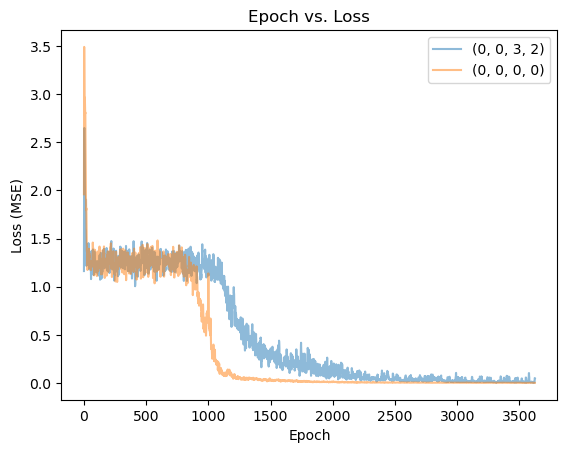

In [28]:
plot_loss(all_losses, size=4)

The LSTM does well with interleaved, reversed data (still need to check for harder formats). Able to achieve close to perfect accuracy on unseen tuples for all carry tables, seems like standard table loss converges more quickly than alternatives but want more robust data.

## Training and Testing Accuracies

In [942]:
import addition_dataloader
import eval
from LSTM import LSTM

In [954]:
with open('../pickles/all_tables.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [1031]:
b = 4
tables = all_tables[b]

In [1033]:
table = tables[((0, 0, 0, 0),
                (0, 0, 0, 0),
                (0, 0, 0, 0),
                (0, 0, 0, 0))]

In [1038]:
model = LSTM(b, 2)

In [1039]:
training_dataloader, testing_dataloader = addition_dataloader.prepare(b, 3, table, split_type='OOD', split_depth=2)

In [1040]:
losses, training_accs, testing_accs = eval.eval(model, training_dataloader, testing_dataloader, num_passes=2000)

t = 0
loss = 1.374033, training_acc = 0.000, testing_acc = 0.021

t = 100
loss = 1.223650, training_acc = 0.062, testing_acc = 0.021

t = 200
loss = 1.170331, training_acc = 0.000, testing_acc = 0.042

t = 300
loss = 1.066880, training_acc = 0.000, testing_acc = 0.000

t = 400
loss = 0.976379, training_acc = 0.188, testing_acc = 0.021

t = 500
loss = 0.903438, training_acc = 0.250, testing_acc = 0.021

t = 600
loss = 0.806774, training_acc = 0.500, testing_acc = 0.146

t = 700
loss = 0.675397, training_acc = 0.438, testing_acc = 0.188

t = 800
loss = 0.404571, training_acc = 0.812, testing_acc = 0.438

t = 900
loss = 0.259190, training_acc = 0.875, testing_acc = 0.604

t = 1000
loss = 0.157041, training_acc = 1.000, testing_acc = 0.875

t = 1100
loss = 0.119898, training_acc = 0.875, testing_acc = 0.833

t = 1200
loss = 0.097918, training_acc = 0.938, testing_acc = 0.729

t = 1300
loss = 0.068158, training_acc = 0.938, testing_acc = 0.958

t = 1400
loss = 0.040762, training_acc = 1.000

Text(0.5, 1.0, 'Learning Metrics vs. Epoch')

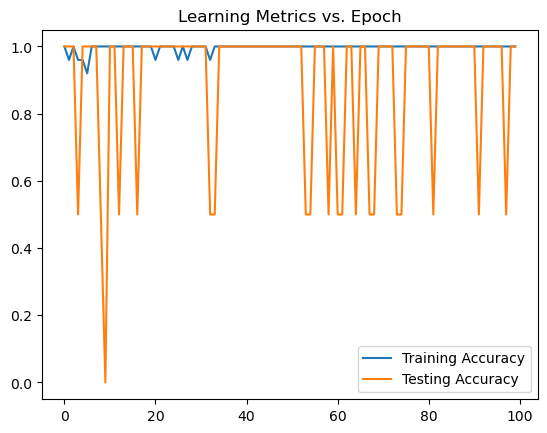

In [975]:
# plt.plot(losses, label='Loss')
plt.plot(training_accs, label='Training Accuracy')
plt.plot(testing_accs, label='Testing Accuracy')
plt.legend()
plt.title('Learning Metrics vs. Epoch')

### Comparing learning metrics for different tables

In [1014]:
with open('../pickles/learning_metrics3.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

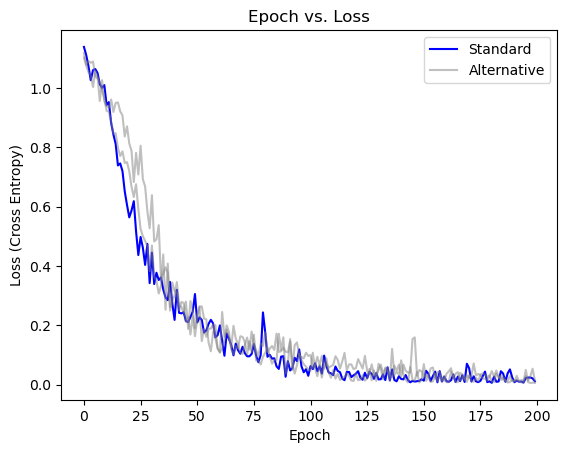

In [1015]:
for dc in learning_metrics.keys():
    loss = learning_metrics[dc]['loss']
    if (np.array(dc) == 0).all():
        plt.plot(loss, color='blue', label='Standard')
    else:
        plt.plot(loss, alpha=0.5, color='grey', label='Alternative')
plt.legend(labels=['Standard', 'Alternative'])
plt.title(f'Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.show()

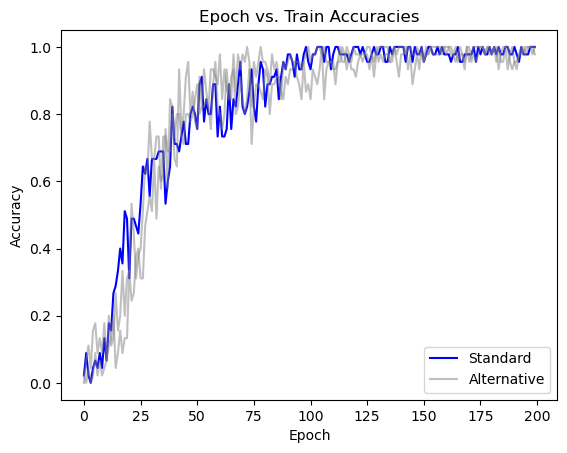

In [1016]:
for dc in learning_metrics.keys():
    train_acc = learning_metrics[dc]['training_acc']
    if (np.array(dc) == 0).all():
        plt.plot(train_acc, color='blue', label='Standard')
    else:
        plt.plot(train_acc, alpha=0.5, color='grey', label='Alternative')
plt.legend(labels=['Standard', 'Alternative'])
plt.title(f'Epoch vs. Train Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

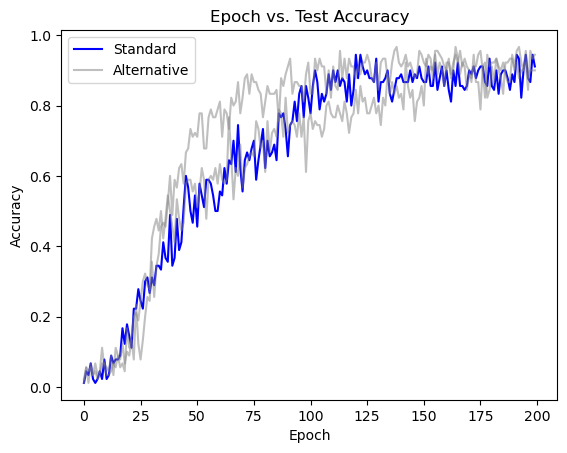

In [1017]:
for dc in learning_metrics.keys():
    train_acc = learning_metrics[dc]['testing_acc']
    if (np.array(dc) == 0).all():
        plt.plot(train_acc, color='blue', label='Standard')
    else:
        plt.plot(train_acc, alpha=0.5, color='grey', label='Alternative')
plt.legend(labels=['Standard', 'Alternative'])
plt.title(f'Epoch vs. Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()